# CASA0006 DSSS: Final Assessment

**Author:** Joe Post  
**Student Number:** 22186870  
**Date:** April 2023  

**[Github repository](https://github.com/joepost/casa0006_assessment)**  

---

# Predicting crash severity using New Zealand transport data

**Abstract:** This notebook ...

## 1. Introduction

### 1.1 Background 

Text ...

### 1.2 Literature Review

Sections to discuss:
- long history of statistical methods in crash analysis; evolution of research focus from statistical to ML methods. Cite review paper here. 
- methodological considerations; use of ensemble (RF) over single decision tree, need for class imbalance methods, etc. 

### 1.3 Research Question

Text ...

## 2. Methodology

Text

## 3. Data Analysis

### 3.1 Setup
To conduct the analysis, the below packages need to be imported.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install imblearn

In [56]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import libpysal
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_validate
from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score, accuracy_score,
                            precision_score, recall_score, classification_report)
from sklearn.inspection import permutation_importance
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score


# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

# preprocessors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

from imblearn.over_sampling import SMOTE   # run SMOTE (synthetic minority oversampling technique)
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# pipeline
from sklearn.pipeline import Pipeline as skPipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# gradient boosting
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier

# feature importance
import rfpimp

# spatial dependence
from pysal.explore import esda
from pysal.lib import weights

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('fivethirtyeight') # specifies that graphs should use ggplot styling
%matplotlib inline

### 3.2 Data cleaning
#### Read data
The CSV file is read in as a pandas data frame, and columns changed to the appropriate data types.

In [3]:
# Read in data
df_raw = pd.read_csv("data/Crash_Analysis_System_CAS_data.csv", na_values = "Null")
df_raw.shape

(807933, 72)

#### Clean missing data
The table below shows the default data type of imported columns, and a count of non-null values for each column. There are 807,933 observations (rows) in the dataset, and 72 features (columns).  

In [4]:
# df.dtypes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807933 entries, 0 to 807932
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          807933 non-null  float64
 1   Y                          807933 non-null  float64
 2   OBJECTID                   807933 non-null  int64  
 3   advisorySpeed              30681 non-null   float64
 4   areaUnitID                 807883 non-null  float64
 5   bicycle                    807928 non-null  float64
 6   bridge                     325939 non-null  float64
 7   bus                        807928 non-null  float64
 8   carStationWagon            807928 non-null  float64
 9   cliffBank                  325939 non-null  float64
 10  crashDirectionDescription  503841 non-null  object 
 11  crashFinancialYear         807933 non-null  object 
 12  crashLocation1             807933 non-null  object 
 13  crashLocation2             80

Of these, 7 have a very high proportion of missing data (>90% of observations) - they are `advisorySpeed`, `crashRoadSideRoad`, `holiday`, `intersection`, `pedestrian`, `temporarySpeedLimit`, and `weatherB`. Through background reading of the [metadata](https://opendata-nzta.opendata.arcgis.com/pages/cas-data-field-descriptions), and investigation of the data, it can be seen that these columns contain a mix of true missing data and incorrectly coded real data. For example, `pedestrian` is defined as a "\[d\]erived variable to indicate how many pedestrians were involved in the crash. This includes pedestrians on skateboards, scooters and wheelchairs." However, non-missing values for `pedestrian` range from \[1,6\], meaning that no crash events have a value of '0' recorded. It is reasonable to assume that crashes with a null value for `pedestrian` actually represent events where no pedestrians were involved, as opposed to events where the number of pedestrians involved were not known or not recorded. Similarly, `holiday` only records an entry if the event falls into one of the four categories of Christmas/New Year, Easter, Labour Weekend, or Queens Birthday. Missing data in this column therefore likely represent events that occurred outside of these holiday dates. 

However, the columns `crashRoadSideRoad` and `intersection` are missing all data, and these were removed from the analysis. For `weatherB`, the observed possible values of 'Strong Wind', 'Frost', 'None' or missing do not align with the metadata description (where values are stated as 'Strong Wind', 'Frost' or 'Unknown'). Due to the ambiguity between 'None' and missing data, this column has been removed. 

For `temporarySpeedLimit` and `advisorySpeed`, missing data represents a true absence - in these cases, no temporary or advisory speed limit was in effect at the time and location of the crash event. Due to the low proportion of observations with a temporary or advisory speed limit in effect, these fields have been converted to boolean - where a present limit is True and no limit classed as False.

Finally, free-text columns have been removed as these will not be useful in the ML model, as well as a series of redundant fields where the information is contained in another variable. These are `OBJECTID`, `areaUnitID`, `crashDirectionDescription`, `crashLocation1`, `crashLocation2`, `crashFinancialYear`, `meshblockId`, `tlaName` and `tlaId`.

In [5]:
checkmissing = df_raw[["pedestrian", "advisorySpeed", 
                   # "holiday", "weatherB",        #commented out as these are non-numeric columns; see cells below
                   "crashRoadSideRoad", "intersection", "temporarySpeedLimit"]]
checkmissing.describe()

,pedestrian,advisorySpeed,crashRoadSideRoad,intersection,temporarySpeedLimit
count,"25,977.0000","30,681.0000",0.0000,0.0000,"12,117.0000"
mean,1.0398,54.4392,NaN,NaN,45.7801
std,0.2309,18.1763,NaN,NaN,19.0041
min,1.0000,10.0000,NaN,NaN,8.0000
25%,1.0000,40.0000,NaN,NaN,30.0000
50%,1.0000,55.0000,NaN,NaN,40.0000
75%,1.0000,65.0000,NaN,NaN,60.0000
max,6.0000,95.0000,NaN,NaN,100.0000


In [6]:
df_raw['holiday'].unique()

array([nan, 'Easter', 'Christmas New Year', 'Labour Weekend',
       'Queens Birthday'], dtype=object)

In [7]:
df_raw['weatherB'].unique()

array([nan, 'Strong wind', 'Frost', 'None'], dtype=object)

In [8]:
df_raw.drop(columns=['OBJECTID', 'areaUnitID', 'crashRoadSideRoad', 'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1', 'crashLocation2', 'meshblockId', 'tlaName', 'tlaId', 'intersection', 'weatherB'], inplace=True)   # drop unwanted columns
df_raw.pedestrian.fillna(value=0, inplace=True)     # replace missing pedestrian values with count of 0
df_raw.holiday.fillna(value="None", inplace=True)   # replace missing holiday values with category 'None'

In [9]:
df_raw.streetLight.fillna(value="Unknown", inplace=True)   # replace missing streetLight values with category 'Unknown'
df_raw.weatherA.fillna(value="Unknown", inplace=True)  # replace missing weather values with category 'unknown'
df_raw.directionRoleDescription.fillna(value="Unknown", inplace=True)  # replace missing direction values with category 'unknown'
df_raw.flatHill.fillna(value="Unknown", inplace=True)  # replace missing hill status with category 'unknown'

In [10]:
temporarySpeedLimit_bool = df_raw["temporarySpeedLimit"].notnull()
df_raw["temporarySpeedLimit_bool"] = temporarySpeedLimit_bool

advisorySpeed_bool = df_raw["advisorySpeed"].notnull()
df_raw["advisorySpeed_bool"] = advisorySpeed_bool

df_raw[["temporarySpeedLimit_bool","advisorySpeed_bool"]]

# REMOVE original tempspeed and advisoryspeed 
df_raw.drop(columns=['temporarySpeedLimit','advisorySpeed'], inplace=True)

A second subset of 23 columns have a non-null count of 325,939, meaning they are missing data for approximately 60% of observations. These are `bridge`, `cliffBank`, `debris`, `ditch`, `fence`, `guardRail`, `houseOrBuilding`, `kerb`, `objectThrownOrDropped`, `otherObject`, `overBank`, `parkedVehicle`, `phoneBoxEtc`, `postOrPole`, `roadworks`, `slipOrFlood`, `strayAnimal`, `trafficIsland`, `trafficSign`, `train`, `tree`, `vehicle`, and `waterRiver`. These columns all collect data on the number of objects of *type* that were struck in the crash, and are systematically either present or missing. Because of the large set of columns in this group, a subset of the dataframe has been created which keeps these columns but removes observations where they have missing data.

In [11]:
# Set up list of columns with low/no missing data
columnsetA = ['bicycle', 'bus', 'carStationWagon',
           'crashSeverity', 'crashSHDescription', 'crashYear',
           'directionRoleDescription', 'fatalCount', 'flatHill', 'light',
           'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
           'otherVehicleType', 'pedestrian', 'region',
           'roadCharacter', 'roadLane', 'roadSurface', 'schoolBus',
           'seriousInjuryCount', 'speedLimit', 'streetLight', 'suv', 'taxi',
           'trafficControl', 'truck', 'unknownVehicleType', 'urban', 'vanOrUtility', 'weatherA']
    
# Set up list of columns with 60% missing data
columnsetB = ['bridge', 'cliffBank', 'debris', 'ditch', 'fence', 'guardRail',
           'houseOrBuilding', 'kerb', 'objectThrownOrDropped', 'otherObject', 'overBank',
           'parkedVehicle', 'phoneBoxEtc', 'postOrPole', 'roadworks', 'slipOrFlood', 'strayAnimal',
           'trafficIsland', 'trafficSign', 'train', 'tree','vehicle','waterRiver']

In [12]:
# Set up subset of dataframe where rows missing data for ColumnSetB are removed
df_cb = df_raw.dropna(axis=0, subset=columnsetB)
df_cb.shape

(325939, 60)

In [13]:
# Use this cell to define the analysis dataset (i.e. df_raw or df_cb)
# The default is to use the ColumnSetB subset
df = df_cb

After removing unnecessary columns and creating the ColumnSetB subset of the dataframe, the data is checked for any remaining missing values.

In [14]:
n_total = df.X.count()
missing = pd.DataFrame(df.isna().sum(axis=0))
missing.rename(columns={0:'nullcount'}, inplace=True)
missing["null_pc"]=missing["nullcount"]/n_total

missing[missing["null_pc"]>0]

,nullcount,null_pc
fatalCount,1,0.0000
minorInjuryCount,1,0.0000
NumberOfLanes,636,0.0020
region,750,0.0023
roadLane,209,0.0006
roadSurface,385,0.0012
seriousInjuryCount,1,0.0000
speedLimit,362,0.0011


The missing values in these columns all represent a very small percentage (<0.05%) of the total observations. Therefore, these observations have been removed. 

In [15]:
# remove any remaining observations with missing data
df = df.dropna(axis="index")
df.shape

(323995, 60)

#### Dependent variable
The outcome variable of interest for this study is the crash severity, which is measured by four variables: 
1. `crashSeverity`: categorised as Non-injury Crash, Minor Crash, Serious Crash, or Fatal Crash
1. `seriousInjuryCount`: count of the serious injuries associated with this crash
1. `fatalCount`: count of the fatal casualties associated with this crash
1. `minorInjuryCount`: count of the non-serious injuries associated with this crash

As fatal count and injury count are all heavily skewed towards zero, crash severity category will be used as the main dependent variable for the ML model. Of the four crash severity categories, there is a comparatively very low count of fatal crashes. Therefore, 'Fatal Crash' and 'Serious Crash' have been combined into a single category for the analysis. 

In [16]:
df['crashSeverity_3cat'] = np.where(df['crashSeverity']=='Fatal Crash', 'Serious/Fatal Crash', 
                                    np.where(df['crashSeverity']=='Serious Crash', 'Serious/Fatal Crash', 
                                             df['crashSeverity']))

df[["crashSeverity", "crashSeverity_3cat"]]

,crashSeverity,crashSeverity_3cat
0,Minor Crash,Minor Crash
1,Fatal Crash,Serious/Fatal Crash
2,Fatal Crash,Serious/Fatal Crash
4,Serious Crash,Serious/Fatal Crash
6,Minor Crash,Minor Crash
...,...,...
807924,Non-Injury Crash,Non-Injury Crash
807925,Non-Injury Crash,Non-Injury Crash
807926,Non-Injury Crash,Non-Injury Crash
807928,Non-Injury Crash,Non-Injury Crash


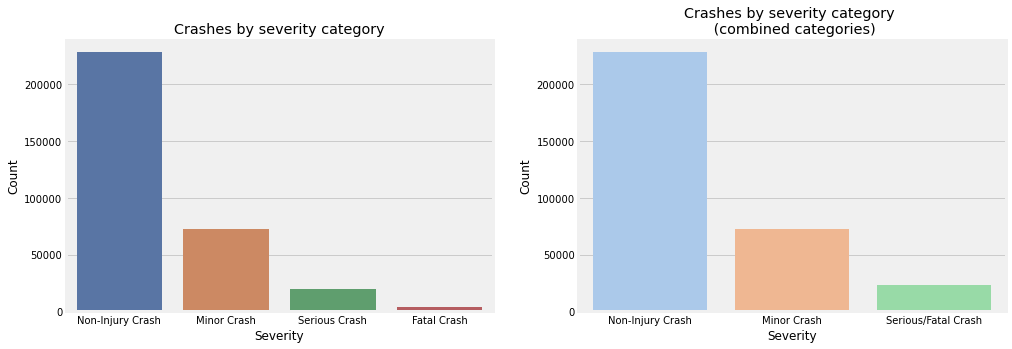

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

# create chart in each subplot
sa1 = sns.countplot(data=df, x='crashSeverity', order=['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash'], ax=axes[0], palette="deep").set(
    title="Crashes by severity category", xlabel="Severity", ylabel="Count")
sa2 = sns.countplot(data=df, x='crashSeverity_3cat', order=['Non-Injury Crash', 'Minor Crash', 'Serious/Fatal Crash'], ax=axes[1], palette="pastel").set(
    title="Crashes by severity category \n (combined categories)", xlabel="Severity", ylabel="Count")

plt.show()

#### Set data types
Several columns in the dataset represent categorical data, where the input has been coded to one value out of a specific set - for example, the local government region where the crash occurred. Categorical columns in the dataframe are set accordingly, and the levels for each category checked to ensure it matches the metadata provided. 

The following columns are converted to categories:  
* `region`
* `crashSeverity`
* `crashSeverity_3cat`
* `crashSHDescription`
* `directionRoleDescription`
* `flatHill`
* `holiday`
* `light`
* `roadCharacter`
* `roadLane`
* `roadSurface`
* `streetLight`
* `trafficControl`
* `urban`
* `weatherA`
* `weatherB`

See below for a summary table (Table 1) of each categorical column, broken down proportionally by category. Tables 2 & 3 show the descriptive statistics for numeric variables, for column sets A and B, respectively.  

In [18]:
# Convert category columns to category type
df = df.astype({
    "region":"category",
    "crashSeverity":"category",
    "crashSeverity_3cat":"category",
    "crashSHDescription":"category",
    "directionRoleDescription":"category",
    "flatHill":"category",
    "holiday":"category",
    "light":"category",
    "roadCharacter":"category",
    "roadLane":"category",
    "roadSurface":"category",
    "streetLight":"category",
    "trafficControl":"category",
    "urban":"category",
    "weatherA":"category"
})

catcols = ["region", "crashSeverity", "crashSeverity_3cat", "crashSHDescription", "directionRoleDescription", "flatHill",
           "holiday", "light", "roadCharacter", "roadLane", "roadSurface", "streetLight", "trafficControl", "urban", "weatherA", 
           # include boolean columns
          "temporarySpeedLimit_bool", "advisorySpeed_bool"]

##### Table 1.  Categorical variables in crash dataset

In [19]:
# create loop of categorical variables to produce summary tables
for i in catcols:
    agg_df = df[[i, 'X']].groupby(i).count().rename(columns={'X':'count'}).sort_values('count', axis=0, ascending=False)
    total = agg_df.sum().values   # store the total as a value
    agg_df['percent'] = round(agg_df['count']/total*100,2)   # calculate row-wise percentage
    print(agg_df)   # print table
    print("\n")

                           count                                  percent
region                                                                   
Auckland Region            90216                                  27.8400
Waikato Region             40554                                  12.5200
Canterbury Region          31554                                   9.7400
Wellington Region          30921                                   9.5400
Otago Region               22147                                   6.8400
Manawatū-Whanganui Region  21349                                   6.5900
Bay of Plenty Region       18333                                   5.6600
Northland Region           16378                                   5.0600
Hawke's Bay Region         14141                                   4.3600
Southland Region            9945                                   3.0700
Taranaki Region             8540                                   2.6400
Gisborne Region             4731      

##### Table 2. Numeric variables in crash data set (Set A: low/no missing data)

In [20]:
df[columnsetA].describe()

,bicycle,bus,carStationWagon,crashYear,fatalCount,minorInjuryCount,moped,motorcycle,NumberOfLanes,otherVehicleType,pedestrian,schoolBus,seriousInjuryCount,speedLimit,suv,taxi,truck,unknownVehicleType,vanOrUtility
count,"323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000"
mean,0.0067,0.0112,1.0831,"2,011.1227",0.0131,0.3070,0.0023,0.0199,2.0989,0.0053,0.0062,0.0005,0.0745,71.4622,0.0824,0.0055,0.0693,0.0026,0.1402
std,0.0839,0.1069,0.7220,6.5563,0.1293,0.6300,0.0488,0.1445,0.6768,0.0734,0.0907,0.0227,0.3145,24.1654,0.2877,0.0783,0.2632,0.0520,0.3658
min,0.0000,0.0000,0.0000,"2,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,1.0000,"2,006.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,1.0000,"2,011.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,1.0000,"2,017.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,5.0000,3.0000,11.0000,"2,022.0000",7.0000,26.0000,4.0000,6.0000,8.0000,2.0000,6.0000,2.0000,14.0000,110.0000,6.0000,5.0000,5.0000,3.0000,6.0000


##### Table 3. Numeric variables in crash data set (Set B: approx. 60% missing data)

In [21]:
df[columnsetB].describe()

,bridge,cliffBank,debris,ditch,fence,guardRail,houseOrBuilding,kerb,objectThrownOrDropped,otherObject,...,postOrPole,roadworks,slipOrFlood,strayAnimal,trafficIsland,trafficSign,train,tree,vehicle,waterRiver
count,"323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000",...,"323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000"
mean,0.0136,0.1064,0.0080,0.0950,0.2106,0.0763,0.0234,0.0353,0.0022,0.0233,...,0.1233,0.0028,0.0024,0.0032,0.0288,0.0486,0.0015,0.1012,0.0254,0.0098
std,0.1173,0.3096,0.0980,0.2956,0.4127,0.2713,0.1521,0.1854,0.0511,0.1529,...,0.3310,0.0549,0.0505,0.0608,0.1688,0.2167,0.0387,0.3050,0.1592,0.0990
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,4.0000,3.0000,7.0000,3.0000,3.0000,4.0000,2.0000,3.0000,4.0000,5.0000,...,4.0000,2.0000,4.0000,3.0000,4.0000,4.0000,1.0000,3.0000,4.0000,2.0000


#### Spatial conversion
The pandas dataframe is converted into a geopandas geodataframe, using the X/Y coordinates provided. These coordinates represent Easting/Northing values in the [NZTM2000](https://www.linz.govt.nz/guidance/geodetic-system/coordinate-systems-used-new-zealand/projections/new-zealand-transverse-mercator-2000-nztm2000) projection, which has the [EPSG code 2193](https://spatialreference.org/ref/epsg/2193/). The geodataframe is then plotted to confirm that the projection has been read as expected. 

A spatial weights matrix is then generated using the *k*-nearest neighbours (KNN) method, where *k*=8, and the distance band method with a threshold of 100m. Global spatial autocorrelation is then calculated using the KNN weights to ensure no neighbourless points. 

In [66]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs = "EPSG:2193") 
gdf.shape

(323995, 66)

Text(0.5, 1.0, 'Traffic Crash Locations, New Zealand, 2000-2022')

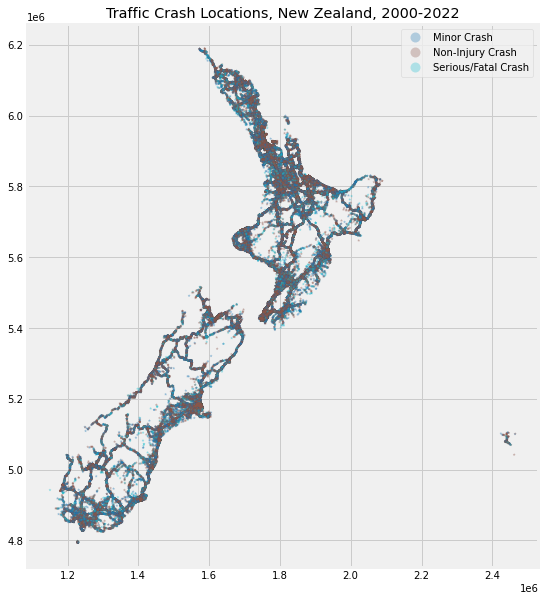

In [64]:
fig, ax = plt.subplots(figsize = (10,10))
gdf.plot(marker='*', 
         # color='blue', 
         column='crashSeverity_3cat',
         alpha=0.3,
         legend=True,
         markersize=5,
        ax=ax)
ax.set_title('Traffic Crash Locations, New Zealand, 2000-2022')

In [67]:
# Generate Weights matrix from the GeoDataFrame
w_knn = weights.KNN.from_dataframe(gdf, k=8)
# Row-standardization
w_knn.transform = "R"

w_knn.weights[4]

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [68]:
w_bdb = weights.distance.DistanceBand.from_dataframe(
    gdf, 100, binary=True
)

w_bdb.weights[4]  # show the neighbour weights for observation 4

[1.0, 1.0]

In [69]:
# Calculate combined injury count measure
# Use this as a numeric input for spatial autocorrelation calculations, that acts as proxy for crash severity category
gdf["injuryCount"] = (gdf.minorInjuryCount + gdf.seriousInjuryCount).astype('int')             # raw count
gdf["IC_std"] = (gdf["injuryCount"] - gdf["injuryCount"].mean()) / gdf["injuryCount"].std()    # standardised 

In [70]:
# Calculate spatial lag

#define weights measure to use
w = w_knn

gdf["IC_lag"] = weights.spatial_lag.lag_spatial(w, gdf["injuryCount"])    # create column: injury count spatial lag
gdf["IC_std_lag"] = weights.spatial_lag.lag_spatial(w, gdf["IC_std"])     # create column: std injury count spatial lag

gdf[["injuryCount", "crashSeverity_3cat", "IC_lag", "IC_std", "IC_std_lag"]]

,injuryCount,crashSeverity_3cat,IC_lag,IC_std,IC_std_lag
0,1,Minor Crash,0.2500,0.8534,-0.1813
1,2,Serious/Fatal Crash,0.2500,2.2331,-0.1813
2,1,Serious/Fatal Crash,0.3750,0.8534,-0.0089
4,5,Serious/Fatal Crash,0.8750,6.3722,0.6810
6,3,Minor Crash,0.6250,3.6128,0.3361
...,...,...,...,...,...
807924,0,Non-Injury Crash,0.0000,-0.5262,-0.5262
807925,0,Non-Injury Crash,0.2500,-0.5262,-0.1813
807926,0,Non-Injury Crash,0.3750,-0.5262,-0.0089
807928,0,Non-Injury Crash,0.2500,-0.5262,-0.1813


"The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. The figure below displays the relationship between Deaths_dens_std and its spatial lag which, because the  W
  that was used is row-standardized, can be interpreted as the average standardized density of cholera deaths in the neighborhood of each observation. The plot displays a positive relationship between both variables. This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values.
  
  In the context of the example, this can be interpreted along the lines of: street segments in the dataset show positive spatial autocorrelation in the density of cholera deaths. This means that street segments with a high level of incidents per 100 metres tend to be located adjacent to other street segments also with high number of deaths, an viceversa" [Source](http://darribas.org/gds15/content/labs/lab_06.html)

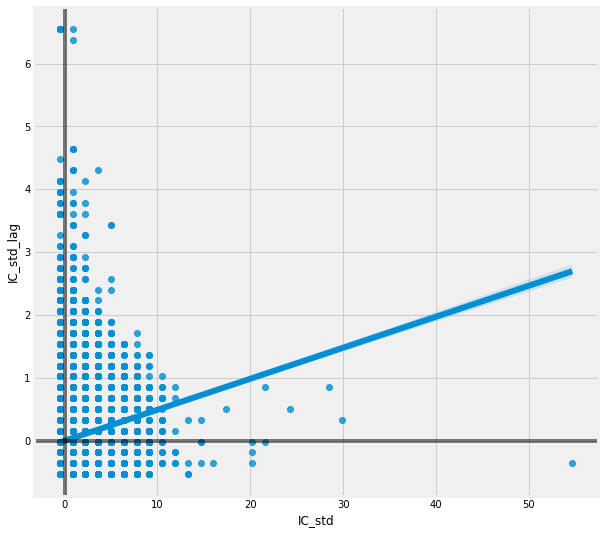

In [30]:
# Plot moran's plot

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='IC_std', y='IC_std_lag', data=gdf)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [71]:
# Calculate Moran's I statistic
mi = esda.Moran(gdf['IC_std_lag'], w)
print(f"Moran's I value: {round(mi.I,3)}; p-value: {mi.p_sim}")

Moran's I value: 0.744; p-value: 0.001


"As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively correlated over space. In terms of our initial goal to find evidence for John Snow's hypothesis that cholera was caused by water in a single contaminated pump, this view seems to align: if cholera was contaminated through the air, it should show a pattern over space -arguably a random one, since air is evenly spread over space- that is much less concentrated than if this was caused by an agent (water pump) that is located at a particular point in space." [Source](http://darribas.org/gds15/content/labs/lab_06.html)

In [72]:
# remove features that will not be included in ML model
gdf.drop(columns=['injuryCount', 'IC_lag', 'IC_std'], inplace=True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 323995 entries, 0 to 807930
Data columns (total 63 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   X                         323995 non-null  float64 
 1   Y                         323995 non-null  float64 
 2   bicycle                   323995 non-null  float64 
 3   bridge                    323995 non-null  float64 
 4   bus                       323995 non-null  float64 
 5   carStationWagon           323995 non-null  float64 
 6   cliffBank                 323995 non-null  float64 
 7   crashSeverity             323995 non-null  category
 8   crashSHDescription        323995 non-null  category
 9   crashYear                 323995 non-null  int64   
 10  debris                    323995 non-null  float64 
 11  directionRoleDescription  323995 non-null  category
 12  ditch                     323995 non-null  float64 
 13  fatalCount           

### 3.3 Fitting and evaluating a model
#### Training Testing Split
Firstly, the dataset is split into training and testing subsets, before any of the preprocessing steps take place. This ensures that there is no data leakage from the testing set, which can lead to inflated performance estimates (Tharwat, 2020). 

In [73]:
# Set inputs for model
data = gdf    # alternative: full dataset 'gdf'
y_var = 'crashSeverity_3cat'

In [74]:
dataX = data.drop(columns=['crashSeverity', 'crashSeverity_3cat'
                           , 'seriousInjuryCount', 'minorInjuryCount', 'fatalCount'
                           # , 'X', 'Y'
                          ])  # create df containing only the predictor variables
dataY = data[y_var]  # create array containing only the classifications/labels

random_state_split = 50
train_x, test_x, train_y, test_y = train_test_split(dataX, dataY, random_state=random_state_split)

In [75]:
print(f"Full dataset size: {data.shape}")

print("Training dataset size:")
print(train_x.shape)
print(train_y.shape)
      
print("Test dataset size:")
print(test_x.shape)
print(test_y.shape)

Full dataset size: (323995, 63)
Training dataset size:
(242996, 58)
(242996,)
Test dataset size:
(80999, 58)
(80999,)


#### Model Pipeline
To prepare the data for modelling, two pre-processing steps are run: standardisation of numeric variables and one-hot encoding of categorical variables. After defining the pre-processing steps, an estimator is added to the ML pipeline, which specifies the ML algorithms to be used. For this project, a remote forest classifier (Breiman 2001) has been chosen. 

In [76]:
# Define preprocessors
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

numerical_columns_selector = make_column_selector(dtype_include="number")
categorical_columns_selector = make_column_selector(dtype_exclude=["number", "geometry"])

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [77]:
# Prepare numeric and categorical column lists

numerical_columns.remove('seriousInjuryCount')   # remove the dependent variables
numerical_columns.remove('fatalCount')           # remove the dependent variables
numerical_columns.remove('minorInjuryCount')           # remove the dependent variables

# numerical_columns.remove('X')           # remove the dependent variables
# numerical_columns.remove('Y')           # remove the dependent variables

categorical_columns.remove('crashSeverity')        # remove the dependent variable
categorical_columns.remove('crashSeverity_3cat')   # remove the dependent variable

catcols_index = [train_x.columns.get_loc(col) for col in categorical_columns]

In [78]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numerical_columns),          # tuple that sets out the name, the transformer to use, and the set of columns to include
        ('categorical', categorical_transformer, categorical_columns)
    ])

In [79]:
#imblearn estimator
rf_model=make_pipeline(column_preprocessor, RandomForestClassifier(random_state=random_state_split))
rf_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['X', 'Y', 'bicycle',
                                                   'bridge', 'bus',
                                                   'carStationWagon',
                                                   'cliffBank', 'crashYear',
                                                   'debris', 'ditch', 'fence',
                                                   'guardRail',
                                                   'houseOrBuilding', 'kerb',
                                                   'moped', 'motorcycle',
                                                   'NumberOfLanes',
                                                   'objectThrownOrDropped',
                                                   'otherObject',
                                                   'otherVehicleType',
                                                   'overBank', 'parkedVeh...
                                                   'speedLimit', 'strayAnimal', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['crashSHDescription',
                                                   'directionRoleDescription',
                                                   'flatHill', 'holiday',
                                                   'light', 'region',
                                                   'roadCharacter', 'roadLane',
                                                   'roadSurface', 'streetLight',
                                                   'trafficControl', 'urban',
                                                   'weatherA',
                                                   'temporarySpeedLimit_bool',
                                                   'advisorySpeed_bool'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=50))])

In [ ]:
start_time = time.time()

rf_model_fit = rf_model.fit(train_x, train_y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the model: {round((elapsed_time)/60,2)} minutes")

In [41]:
# Evaluate random forest model
print(f"Training score: {rf_model_fit.score(train_x, train_y)}")
print(f"Test score: {rf_model_fit.score(test_x, test_y)}")

Training score: 0.9947241929908311
Test score: 0.7020580500993839


#### Evaluating performance
The `balanced_accuracy_score` function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. Additionally, the geometric mean (G-mean), calculated as the square root of the product of sensitivity and specificity measures, has been proposed as a more appropriate metric for evaluating models developed from imbalanced datasets (Jeong et al. 2018). 

In [42]:
y_predict = rf_model.predict(test_x)
y_true = test_y

In [43]:
print(classification_report_imbalanced(y_true, y_predict))

                           pre       rec       spe        f1       geo       iba       sup

        Minor Crash       0.40      0.13      0.94      0.19      0.35      0.11     18311
   Non-Injury Crash       0.73      0.95      0.18      0.83      0.41      0.18     56881
Serious/Fatal Crash       0.40      0.09      0.99      0.14      0.29      0.08      5807

        avg / total       0.63      0.70      0.41      0.63      0.39      0.16     80999



In [44]:
print(f"The accuracy score is: {round(accuracy_score(y_true, y_predict),3)}")
print(f"The balanced accuracy score is: {round(balanced_accuracy_score(y_true, y_predict),3)}")

The accuracy score is: 0.702
The balanced accuracy score is: 0.388


#### Iterate through multiple models

After testing proof-of-concept with the RF model above, a loop is built to iterate through alternative models and compare the performance results. In the ML literature, there are two main approaches to dealing with class imbalanced data: under-sampling and over-sampling (Wen et al. 2019). Due to the large size of the cleaned dataset (still over 300,000 observations), an undersampling method has been applied, as this maintains a high performance but at significantly reduced computational load.

In [45]:
# Set the below to 'True' to run the model iteration cell
run_tuning = True

In [46]:
if run_tuning == True:

    # Compare multiple model variations in a single method
    start_time = time.time()

    classifiers = {
        'RF': RandomForestClassifier(random_state=random_state_split),
        'RF_balanced': BalancedRandomForestClassifier(random_state=random_state_split),
        'BBC': BalancedBaggingClassifier(sampler=RandomUnderSampler(), random_state=random_state_split),
        # 'XGBoost': XGBClassifier(random_state=random_state_split),
        'AdaBoost': EasyEnsembleClassifier(random_state=random_state_split)
    }

    # a dict to store the evaluation output of training and testing data
    dict_results = dict()

    for name, classifier in classifiers.items():
        model = imbPipeline(steps = [
       ('column_preprocessor', column_preprocessor),
       ('classifier', classifier)
        ])

        model_fit = model.fit(train_x, train_y)

        y_predict = model_fit.predict(test_x)
        y_predict_train = model_fit.predict(train_x)

        # predictions = model.predict(test_x)
        dict_results[name] = [model_fit.score(train_x, train_y),   # accuracy score of training data
                              model_fit.score(test_x, test_y),     # accuracy score of test data
                              balanced_accuracy_score(test_y, y_predict),  # balanced accuracy 
                              geometric_mean_score(test_y, y_predict)   # geometric mean
                             ]

    # transform dict_models to dataframe
    df_models = pd.DataFrame.from_dict(dict_results, orient='index', 
                                       columns=['Training accuracy', 'Testing accuracy', 'Balanced testing accuracy', 'Geometric Mean'])

    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the model iteration: {round((elapsed_time)/60,2)} minutes")
    
else:
    print("Model iteration not run.")

Elapsed time to compute the model iteration: 5.39 minutes


In [50]:
df_models

,Training accuracy,Testing accuracy,Balanced testing accuracy,Geometric Mean
RF,0.9947,0.7021,0.3885,0.2202
RF_balanced,0.7199,0.5150,0.4923,0.4849
BBC,0.7049,0.5211,0.4559,0.4475
AdaBoost,0.5392,0.5383,0.4937,0.4792


In [47]:
# Define final model as Balanced RF
rf_model=make_pipeline(column_preprocessor, BalancedRandomForestClassifier(random_state=random_state_split))
rf_model_fit = rf_model.fit(train_x, train_y)

rf_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['bicycle', 'bridge', 'bus',
                                                   'carStationWagon',
                                                   'cliffBank', 'crashYear',
                                                   'debris', 'ditch', 'fence',
                                                   'guardRail',
                                                   'houseOrBuilding', 'kerb',
                                                   'moped', 'motorcycle',
                                                   'NumberOfLanes',
                                                   'objectThrownOrDropped',
                                                   'otherObject',
                                                   'otherVehicleType',
                                                   'overBank', 'parkedVehicle',
                                                   'p...
                                                   'suv', 'taxi', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['crashSHDescription',
                                                   'directionRoleDescription',
                                                   'flatHill', 'holiday',
                                                   'light', 'region',
                                                   'roadCharacter', 'roadLane',
                                                   'roadSurface', 'streetLight',
                                                   'trafficControl', 'urban',
                                                   'weatherA',
                                                   'temporarySpeedLimit_bool',
                                                   'advisorySpeed_bool'])])),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(random_state=50))])

#### Hyperparameter tuning
The following method finds the optimal values for RF hyperparameters, from the specified set. For this model, the best performing set used a max tree depth of 50 and a minimum leaf sample of 2.   

**NOTE:** The tuning cell takes approximately 40 minutes to run. Therefore, has been default set to not run, unless explicitly called by setting `run_tuning` to True.

In [ ]:
# Set the below to 'True' to run the hyperparameter tuning cell
run_tuning = False

In [ ]:
if run_tuning == True:
    start_time = time.time()
    
    # grid_params is the range of each hyperparameter
    grid_params = {  
        'randomforestclassifier__max_depth': [10,20,50],           #NOTE: the identifier of this name needs to change to match the model estimator
        'randomforestclassifier__min_samples_split': [2,4,6,8]   
    }
    search = GridSearchCV(rf_model, 
                      grid_params, 
                      verbose=2)    # controls the message output; v=2 computation time for each fold and parameter candidate are displayed
    search.fit(train_x, train_y)
    print("Best Score: ", search.best_score_)
    print("Best Params: ", search.best_params_)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the hyperparameter tuning: {round((elapsed_time)/60,2)} minutes")
    
else:
    print("Hyperparameter tuning not run.")

#### Cross-validation

In [ ]:
# Perform cross-validation
start_time = time.time()

cv_results = cross_validate(rf_model, train_x, train_y, cv=5, scoring='balanced_accuracy')

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the cross-validation: {round((elapsed_time)/60,2)} minutes")

pd.DataFrame.from_dict(cv_results,orient = 'index')

In [ ]:
scores = cv_results["test_score"]
print("The mean cross-validation balanced accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

In [ ]:
y_predict = rf_model_fit.predict(test_x)
y_true = test_y

print(classification_report_imbalanced(y_true, y_predict))

#### Interpreting feature importance

Permutation feature importance (PFI) method. "Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set." [sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

In [ ]:
# Generate list of feature names, to use as index for feature importance 
all_columns_selector = make_column_selector()

all_columns = all_columns_selector(data)

all_columns.remove('seriousInjuryCount') 
all_columns.remove('minorInjuryCount') 
all_columns.remove('fatalCount')           
all_columns.remove('crashSeverity')        
all_columns.remove('crashSeverity_3cat')  
# all_columns.remove('X')
# all_columns.remove('Y')

len(all_columns)

In [ ]:
# start_time = time.time()
# pfi = permutation_importance(
#     rf_model_fit, test_x, test_y, n_repeats=5, random_state=random_state_split, n_jobs=2
# )

# forest_importances = pd.Series(pfi.importances_mean
#                                , index=all_columns
#                               )

# elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
# for i in pfi.importances_mean.argsort()[::-1]:
#      if pfi.importances_mean[i] - 2 * pfi.importances_std[i] > 0:
#         print(f"{all_columns[i]:<8}  "
#                f"{pfi.importances_mean[i]:.3f}"
#                f" +/- {pfi.importances_std[i]:.3f}")

In [ ]:
# forest_importances

In [ ]:
# forest_importances.plot.bar()
# # Set the Bar Plot Labels and Title
# plt.xlabel("year",  size = 20)
# plt.ylabel("people", size = 20)

In [48]:
# the importances function returns a dataframe of two columns, Feature and Importance, and the features are ranked from the most important to the least.
imp = rfpimp.importances(rf_model, test_x, test_y)
print(imp)

                                                       Importance
Feature                                                          
carStationWagon                                            0.0262
urban                                                      0.0168
parkedVehicle                                              0.0148
crashSHDescription                                         0.0090
directionRoleDescription                                   0.0082
fence                                                      0.0068
truck                                                      0.0064
motorcycle                                                 0.0062
crashYear                                                  0.0062
speedLimit                                                 0.0058
postOrPole                                                 0.0052
bicycle                                                    0.0046
trafficSign                                                0.0046
vehicle   

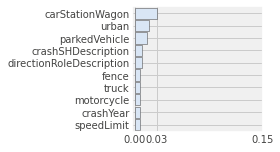

In [49]:
imphead = imp[0:10]
imphead

# Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imphead)
viz.view()

## 4. Discussion

Sections for discussion: 
- importance of addressing class imbalance, and how this affects the accuracy of the model. Easy to overlook due to traditional metrics (e.g. overall accuracy score) masking the poor class-wise performance. 
- Interpretation of feature importance; which columns have the greatest influence? How does this translate into practice for transport engineers, urban planners, etc.?
- Addressing the spatial component? 


## 5. Conclusion

Text ...


## References

1. Breiman, L. (2001) ‘Random Forests’, *Machine Learning*, 45(1), pp. 5–32. Available at: https://doi.org/10.1023/A:1010933404324.
